In [1]:
import sys
sys.path.insert(0, '/Users/admin-wana/Projects/finance-tweets-builder')

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from config.database import execute_query
from datetime import datetime

In [2]:
# 1. Carregar os tweets do DB
select_query = """
SELECT pub_text, TO_CHAR(pub_date, 'YYYY-MM-DD') as pub_date, sentiment, symbol 
FROM tweets 
WHERE symbol = 'AAPL' AND sentiment IS NOT NULL LIMIT 1000
"""
tweets = execute_query(select_query)
df_tweets = pd.DataFrame(tweets)
df_tweets.head()

,pub_text,pub_date,sentiment,symbol
0,"$AAPL\n Feels So Good , from 311 !!",2025-02-25,BULLISH,AAPL
1,$SPY I have been bearish on things like $TSLA ...,2025-02-23,BEARISH,AAPL
2,$AAPL Bullish,2025-02-22,BULLISH,AAPL
3,$AAPL BREAKING: President Trump has announced ...,2025-02-21,NEUTRAL,AAPL
4,$AAPL Damn. Is this where all the Launderers a...,2025-02-21,BEARISH,AAPL


In [3]:
# 2. Converter sentimento para numérico (exemplo simples)
sentiment_map = {"BULLISH": 1, "BEARISH": -1}  # ajuste conforme suas categorias
df_tweets['sentiment_numeric'] = df_tweets['sentiment'].map(sentiment_map)

# 3. Agregar sentimento diário (média ou soma)
df_sentiment = df_tweets.groupby('pub_date')['sentiment_numeric'].mean().reset_index()
df_sentiment['pub_date'] = pd.to_datetime(df_sentiment['pub_date'])

df_sentiment.head()

,pub_date,sentiment_numeric
0,2025-02-20,0.044025
1,2025-02-21,-0.106742
2,2025-02-22,0.142857
3,2025-02-23,-0.238095
4,2025-02-24,-0.111111


In [4]:
# 4. Obter dados de fechamento via yfinance
end = datetime.now().strftime('%Y-%m-%d')
start = (datetime.now() - pd.Timedelta(days=365)).strftime('%Y-%m-%d')
df_prices = yf.download('AAPL', start=start, end=end)[['Close']]
df_prices.reset_index(inplace=True)
df_prices.rename(columns={'Date': 'pub_date'}, inplace=True)

# Flatten das colunas caso haja MultiIndex
if isinstance(df_prices.columns, pd.MultiIndex):
    df_prices.columns = df_prices.columns.get_level_values(0)

df_prices.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,pub_date,Close
0,2024-04-11,174.217377
1,2024-04-12,175.720276
2,2024-04-15,171.878403
3,2024-04-16,168.583984
4,2024-04-17,167.210464


In [5]:
# Realiza o merge preservando todas as datas dos preços
df_merge = pd.merge(df_prices, df_sentiment, on='pub_date', how='left')

# Preenche valores NaN de sentimento com 0
df_merge['sentiment_numeric'] = df_merge['sentiment_numeric'].fillna(0)

df_merge.head()

,pub_date,Close,sentiment_numeric
0,2024-04-11,174.217377,0.0
1,2024-04-12,175.720276,0.0
2,2024-04-15,171.878403,0.0
3,2024-04-16,168.583984,0.0
4,2024-04-17,167.210464,0.0


In [6]:
# 6. Análise da correlação
correlation = df_merge['sentiment_numeric'].corr(df_merge['Close'])
print(f"Correlação: {correlation}")



Correlação: -0.07667114723424111


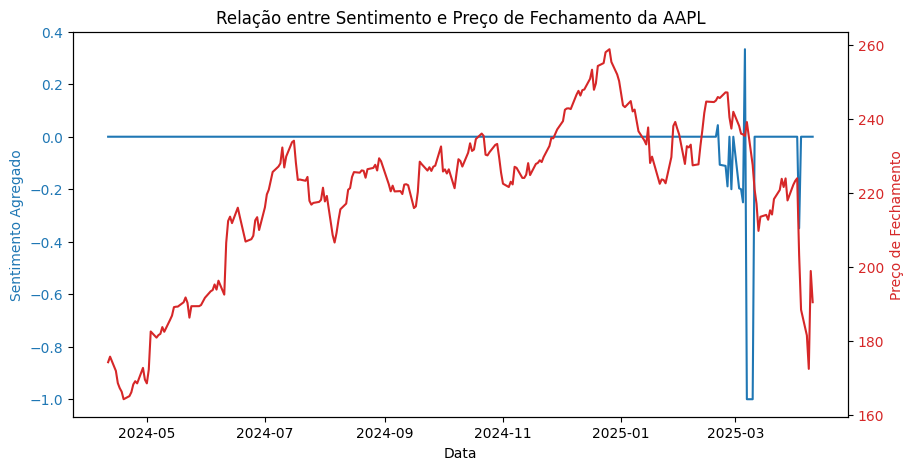

In [7]:
# 7. Visualização com eixo x em 'pub_date' e dois eixos y para sentiment_numeric e Close
plt.figure(figsize=(10, 5))
plt.plot(df_merge['pub_date'], df_merge['sentiment_numeric'], color='tab:blue', label='Sentimento Agregado')
plt.xlabel("Data")
plt.ylabel("Sentimento Agregado", color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

ax2 = plt.twinx()
ax2.plot(df_merge['pub_date'], df_merge['Close'], color='tab:red', label='Preço de Fechamento')
ax2.set_ylabel("Preço de Fechamento", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Relação entre Sentimento e Preço de Fechamento da AAPL")
plt.show()